In [1]:
model_names = ["Original_Pretrained_R2plus1DMotionSegNet.pth"]

In [2]:
import os
os.chdir("/home/wang/workspace/JupyterNoteBooksAll/fully-automated-multi-heartbeat-echocardiography-video-segmentation-and-motion-tracking")
print(os.getcwd())

%config Completer.use_jedi = False

import SimpleITK as itk
from LabelFusion.wrapper import fuse_images

import echonet
from echonet.datasets import Echo

import torch.nn.functional as F
from torchvision.models.video import r2plus1d_18
from torch.utils.data import Dataset, DataLoader, Subset
from multiprocessing import cpu_count

from src.utils.torch_utils import TransformDataset, torch_collate
from src.utils.echo_utils import get2dPucks
from src.utils.camus_validate import cleanupSegmentation
from src.transform_utils import generate_2dmotion_field
from src.visualization_utils import categorical_dice
from src.loss_functions import huber_loss, convert_to_1hot, convert_to_1hot_tensor
from src.echonet_dataset import EDESpairs, EchoNetDynamicDataset

from src.model.R2plus1D_18_MotionNet import R2plus1D_18_MotionNet

# v1 dropout, not in place dropout
from src.model.dropout_0_10_R2plus1D_18_MotionNet import dropout_0_10_R2plus1D_18_MotionNet
from src.model.dropout_0_25_R2plus1D_18_MotionNet import dropout_0_25_R2plus1D_18_MotionNet
from src.model.dropout_0_50_R2plus1D_18_MotionNet import dropout_0_50_R2plus1D_18_MotionNet
from src.model.dropout_0_75_R2plus1D_18_MotionNet import dropout_0_75_R2plus1D_18_MotionNet

# v2 dropout (in place before motion heads)
from src.model.dropout_v2_0_00_R2plus1D_18_MotionNet import dropout_v2_0_00_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_10_R2plus1D_18_MotionNet import dropout_v2_0_10_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_25_R2plus1D_18_MotionNet import dropout_v2_0_25_R2plus1D_18_MotionNet



# from src.visualization_utils import categorical_dice

import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import random
import pickle
import time

tic, toc = (time.time, time.time)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

/home/wang/workspace/JupyterNoteBooksAll/fully-automated-multi-heartbeat-echocardiography-video-segmentation-and-motion-tracking


'cuda'

In [3]:
batch_size = 4
num_workers = max(4, cpu_count()//2)


def worker_init_fn_valid(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    

def worker_init_fn(worker_id):
    # See here: https://pytorch.org/docs/stable/notes/randomness.html#dataloader
    # and the original post of the problem: https://github.com/pytorch/pytorch/issues/5059#issuecomment-817373837
    worker_seed = torch.initial_seed() % 2 ** 32
    print(f'worker_seed: {worker_seed}')
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    

def permuter(list1, list2):
    for i1 in list1:
        for i2 in list2:
            yield (i1, i2)
            

param_trainLoader = {'collate_fn': torch_collate,
                     'batch_size': batch_size,
                     'num_workers': max(4, cpu_count()//2),
                     'worker_init_fn': worker_init_fn}

param_testLoader = {'collate_fn': torch_collate,
                    'batch_size': batch_size,
                    'shuffle': False,
                    'num_workers': max(4, cpu_count()//2),
                    'worker_init_fn': worker_init_fn}

paramLoader = {'train': param_trainLoader,
               'valid': param_testLoader,
               'test':  param_testLoader}

In [4]:
with open("fold_indexes/stanford_valid_sampled_indices", "rb") as infile:
    valid_mask = pickle.load(infile)
infile.close()

full_dataset = EchoNetDynamicDataset(split='val', clip_length="full", subset_indices=valid_mask, period=1)
test_dataset = EchoNetDynamicDataset(split='test', clip_length="full", raise_for_es_ed=False, period=1)
random_test_dataset = EchoNetDynamicDataset(split='test', clip_length=32, raise_for_es_ed=True, period=1)



100%|██████████| 16/16 [00:01<00:00, 13.64it/s]


In [5]:
loaded_in_models = []

for model_name in model_names:
    model_save_path = f"save_models/{model_name}"
     
    
    if model_name == 'Original_Pretrained_R2plus1DMotionSegNet.pth':
        model_template_obj = R2plus1D_18_MotionNet()
    elif model_name == 'dropout_v2_0_00_R2plus1DMotionSegNet.pth':
        model_template_obj = dropout_v2_0_00_R2plus1D_18_MotionNet()
        
    elif model_name == "dropout_v3_0_00_R2plus1D_18_MotionNet.pth":
        model_template_obj = dropout_v3_0_00_R2plus1D_18_MotionNet()
    elif model_name == "dropout_v3_0_10_R2plus1D_18_MotionNet.pth":
        model_template_obj = dropout_v3_0_10_R2plus1D_18_MotionNet()
    elif model_name == "dropout_v3_0_25_R2plus1D_18_MotionNet.pth":
        model_template_obj = dropout_v3_0_25_R2plus1D_18_MotionNet()
    elif model_name == "dropout_v4_0_00_R2plus1D_18_MotionNet.pth":
        model_template_obj = dropout_v4_0_00_R2plus1D_18_MotionNet()
    elif model_name == "dropout_v4_0_10_R2plus1D_18_MotionNet.pth":
        model_template_obj = dropout_v4_0_10_R2plus1D_18_MotionNet()
    elif model_name == "dropout_v4_0_25_R2plus1D_18_MotionNet.pth":
        model_template_obj = dropout_v4_0_25_R2plus1D_18_MotionNet()


    model = torch.nn.DataParallel(model_template_obj)


    
    model.to("cuda")
    torch.cuda.empty_cache()
    model.load_state_dict(torch.load(model_save_path)["model"])
    print(f'{model_name} has {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters.')
    model.eval();
    
    loaded_in_models.append((model_name, model))

print(len(loaded_in_models))

Original_Pretrained_R2plus1DMotionSegNet.pth has 31575731 parameters.
1


In [6]:
# test_pat_index = np.random.randint(len(test_dataset))
test_pat_index = 0 

video, (filename, EF, es_clip_index, ed_clip_index, es_index, ed_index, es_frame, ed_frame, es_label, ed_label) = test_dataset[test_pat_index]

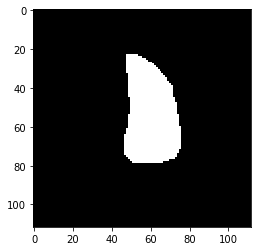

In [7]:
plt.imshow(ed_label, cmap='gray')

In [8]:
def divide_to_consecutive_clips(video, clip_length=32, interpolate_last=False):
    source_video = video.copy()
    video_length = video.shape[1]
    left = video_length % clip_length
    if left != 0 and interpolate_last:
        source_video = torch.Tensor(source_video).unsqueeze(0)
        source_video = F.interpolate(source_video, size=(int(np.round(video_length / clip_length) * clip_length), 112, 112),
                                     mode="trilinear", align_corners=False)
        source_video = source_video.squeeze(0).squeeze(0)
        source_video = source_video.numpy()
    
    videos = np.empty(shape=(1, 3, clip_length, 112, 112))

    for start in range(0, int(clip_length * np.round(video_length / clip_length)), clip_length):
        one_clip = source_video[:, start: start + clip_length]
        one_clip = np.expand_dims(one_clip, 0)
        videos = np.concatenate([videos, one_clip])
    return videos[1:]


# goes thru a video and annotates where we can start clips given video length, clip length, etc.
def get_all_possible_start_points(ed_index, es_index, video_length, clip_length):
    assert es_index - ed_index > 0, "not a ED to ES clip pair"
    possible_shift = clip_length - (es_index - ed_index)
    allowed_right = video_length - es_index
    if allowed_right < possible_shift:
        return np.arange(ed_index - possible_shift + 1, video_length - clip_length + 1)
    if possible_shift < 0:
        return np.array([ed_index])
    elif ed_index < possible_shift:
        return np.arange(ed_index + 1)
    else:
        return np.arange(ed_index - possible_shift + 1, ed_index + 1)

In [9]:
possible_starts = get_all_possible_start_points(ed_index, es_index, video.shape[1], clip_length=32)
print(len(possible_starts))
print(possible_starts)

16
[117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132]


In [10]:
ed_index, es_index

(132, 148)

In [11]:
delta_ed_es = es_index - ed_index
delta_ed_es

16

In [12]:
# segment using all models
all_segmentation_outputs = []
all_motion_outputs = []

# for each model, segment the clips
for name, model in loaded_in_models:
    
    segmentation_outputs = np.empty(shape=(1, 2, 32, 112, 112))
    motion_outputs = np.empty(shape=(1, 4, 32, 112, 112))
    for start in possible_starts:
        one_clip = np.expand_dims(video[:, start: start + 32], 0)
        segmentation_output, motion_output = model(torch.Tensor(one_clip))
        segmentation_outputs = np.concatenate([segmentation_outputs, segmentation_output.cpu().detach().numpy()])
        motion_outputs = np.concatenate([motion_outputs, motion_output.cpu().detach().numpy()])
    segmentation_outputs = segmentation_outputs[1:]
    motion_outputs = motion_outputs[1:]
    
    # save 
    all_segmentation_outputs.append(segmentation_outputs)
    all_motion_outputs.append(motion_outputs)


In [13]:
motion_trackings = all_motion_outputs[0]
segmentations = all_segmentation_outputs[0]
segmentations.shape, motion_trackings.shape

((16, 2, 32, 112, 112), (16, 4, 32, 112, 112))

In [34]:
segmentations_1 = segmentations[-1]
motions_1 = motion_trackings[-1]

segmentations_1.shape, motions_1.shape

((2, 32, 112, 112), (4, 32, 112, 112))

In [14]:
new_segmentations = np.argmax(segmentations, 1)

In [15]:
new_segmentations.shape

(16, 32, 112, 112)

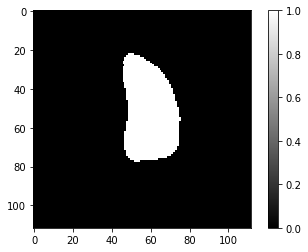

In [16]:
plt.imshow(new_segmentations[0][0], cmap="gray")
plt.colorbar()

In [17]:
new_segmentations.shape, motion_trackings.shape

((16, 32, 112, 112), (16, 4, 32, 112, 112))

In [18]:
segmentation_last_clip_in_consecutive_clips_list = new_segmentations[-1]
motions_last_clip_in_consecutive_clips_list = motion_trackings[-1]
segmentation_last_clip_in_consecutive_clips_list.shape, motions_last_clip_in_consecutive_clips_list.shape

((32, 112, 112), (4, 32, 112, 112))

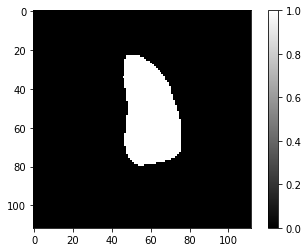

In [19]:
ed_seg_frame = segmentation_last_clip_in_consecutive_clips_list[0]

plt.imshow(ed_seg_frame, cmap="gray")
plt.colorbar()

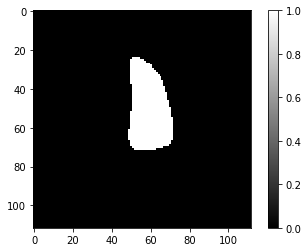

In [20]:
es_seg_frame = segmentation_last_clip_in_consecutive_clips_list[delta_ed_es]

plt.imshow(es_seg_frame, cmap="gray")
plt.colorbar()

In [21]:
def generate_2dmotion_field_PLAY(x, offset):
    # Qin's code for joint_motion_seg learning works fine on our purpose too
    # Same idea https://discuss.pytorch.org/t/warp-video-frame-from-optical-flow/6013/5
    # print(x.shape)
    
    
    x_shape = x.shape
    print(f'x_shape: {x_shape}')
    
    grid_w, grid_h = torch.meshgrid([torch.linspace(-1, 1, x_shape[2]), torch.linspace(-1, 1, x_shape[3])])  # (h, w)
    print(f'grid_w.shape (meshgrid): {grid_w.shape}')
    print(f'grid_h.shape (meshgrid): {grid_h.shape}')
    
    # this should just be moving the vars to gpu mem and doing some data type conversion to some
    # floating point precision
    grid_w = grid_w.cuda().float()
    grid_h = grid_h.cuda().float()
    
    print(f'grid_w.shape .cuda().float(): {grid_w.shape}')
    print(f'grid_h.shape .cuda().float(): {grid_h.shape}')

    grid_w = nn.Parameter(grid_w, requires_grad=False)
    grid_h = nn.Parameter(grid_h, requires_grad=False)
    print(f'grid_w.shape (nn.Param): {grid_w.shape}')
    print(f'grid_h.shape (nn.Param): {grid_h.shape}')


    offset_h, offset_w = torch.split(offset, 1, 1)
    
    print(f'offset_h.shape (split): {offset_h.shape}')
    print(f'offset_w.shape (split): {offset_w.shape}')
    
    offset_w = offset_w.contiguous().view(-1, int(x_shape[2]), int(x_shape[3]))  # (b*c, h, w)
    offset_h = offset_h.contiguous().view(-1, int(x_shape[2]), int(x_shape[3]))  # (b*c, h, w)
    
    print(f'offset_h.shape (contiguous): {offset_h.shape}')
    print(f'offset_w.shape (contiguous): {offset_w.shape}')
    
    offset_w = grid_w + offset_w
    offset_h = grid_h + offset_h
    
    print(f'offset_w (grid_w + offset_w): {offset_w.shape}')
    print(f'offset_h (grid_h + offset_h): {offset_h.shape}')
    
    offsets = torch.stack((offset_h, offset_w), 3)
    
    print(f'offsets (stack): {offsets.shape}')

    print('leaving generate_2dmotion_field')
    return offsets

In [35]:
motion_output.shape

torch.Size([1, 4, 32, 112, 112])

In [22]:
frame_index = 0 # first frame in clip

forward_motion = motion_output[:, :2, frame_index,...]

In [ ]:
forward_motion.shape

In [23]:
flow_source = segmentations[frame_index]
print(flow_source.shape)

(2, 32, 112, 112)


In [24]:
flow_source = np.array([flow_source[:, frame_index, ...]])
flow_source.shape

(1, 2, 112, 112)

In [25]:
motion_field = generate_2dmotion_field_PLAY(flow_source, forward_motion)

x_shape: (1, 2, 112, 112)
grid_w.shape (meshgrid): torch.Size([112, 112])
grid_h.shape (meshgrid): torch.Size([112, 112])
grid_w.shape .cuda().float(): torch.Size([112, 112])
grid_h.shape .cuda().float(): torch.Size([112, 112])
grid_w.shape (nn.Param): torch.Size([112, 112])
grid_h.shape (nn.Param): torch.Size([112, 112])
offset_h.shape (split): torch.Size([1, 1, 112, 112])
offset_w.shape (split): torch.Size([1, 1, 112, 112])
offset_h.shape (contiguous): torch.Size([1, 112, 112])
offset_w.shape (contiguous): torch.Size([1, 112, 112])
offset_w (grid_w + offset_w): torch.Size([1, 112, 112])
offset_h (grid_h + offset_h): torch.Size([1, 112, 112])
offsets (stack): torch.Size([1, 112, 112, 2])
leaving generate_2dmotion_field


In [26]:
flow_source = torch.from_numpy(flow_source).to(device).float()

next_label = F.grid_sample(flow_source, motion_field, align_corners=False, mode="bilinear", padding_mode='border')

In [27]:
next_label.shape

torch.Size([1, 2, 112, 112])

In [28]:
next_frame = next_label.cpu().detach().numpy()

In [29]:
type(next_frame)

numpy.ndarray

In [30]:
next_frame.shape

(1, 2, 112, 112)

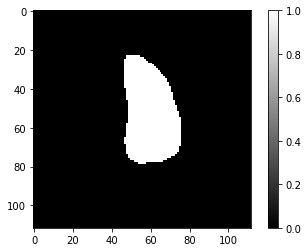

In [31]:
next_frame = np.argmax(next_frame, 1)

plt.imshow(next_frame[0], cmap='gray')
plt.colorbar()

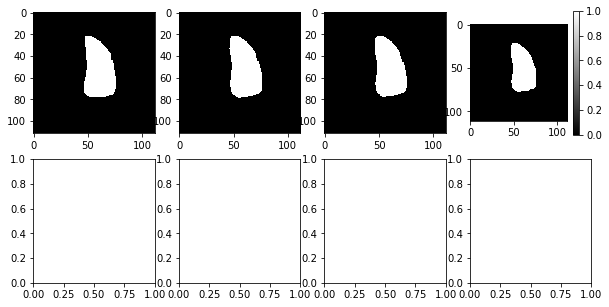

In [33]:
fig, ax = plt.subplots(2, 4, figsize=(10, 5))

ed_plus_one_frame = segmentation_last_clip_in_consecutive_clips_list[1]

ax[0][0].imshow(ed_label, cmap='gray')
ax[0][1].imshow(ed_seg_frame, cmap='gray')
ax[0][2].imshow(ed_plus_one_frame, cmap='gray')
ax_img = ax[0][3].imshow(next_frame[0], cmap='gray')
fig.colorbar(ax_img, ax=ax[0][3])

## Now start from ED seg frame and warp the number frames till we get our pseudo ES frame

In [ ]:
for i in range(delta_ed_es):
    frame_index = i

    forward_motion = motions_1[:, :2, frame_index,...]
    
    flow_source = segmentations_1[frame_index]